In [27]:
# Import Everything Here
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau

In [28]:
path_keraton = r"/kaggle/input/indonesian-batik-motifs/batik-keraton/*"
path_cendrawasih = r"/kaggle/input/indonesian-batik-motifs/batik-cendrawasih/*"
path_bali = r"/kaggle/input/indonesian-batik-motifs/batik-bali/*"

In [29]:
def extractData(path, label):
    data = []
    for file in glob.iglob(path):
        img = cv2.imread(file)
        if img is None:
            print(f"Failed to read image: {file}")
            continue  # Skip this image and continue with the next one
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        data.append((img, label))  

    return data

'''
label             mapping
batik_keraton       0
batik_cendrawasih   1
batik_bali          2
'''

batik_keraton = extractData(path_keraton, 0)
batik_cendrawasih = extractData(path_cendrawasih, 1)
batik_bali = extractData(path_bali, 2)

dataset = batik_keraton + batik_cendrawasih + batik_bali

# Splitting data and labels
data = np.array([item[0] for item in dataset])
labels = np.array([item[1] for item in dataset])

Failed to read image: /kaggle/input/indonesian-batik-motifs/batik-cendrawasih/18.jpg


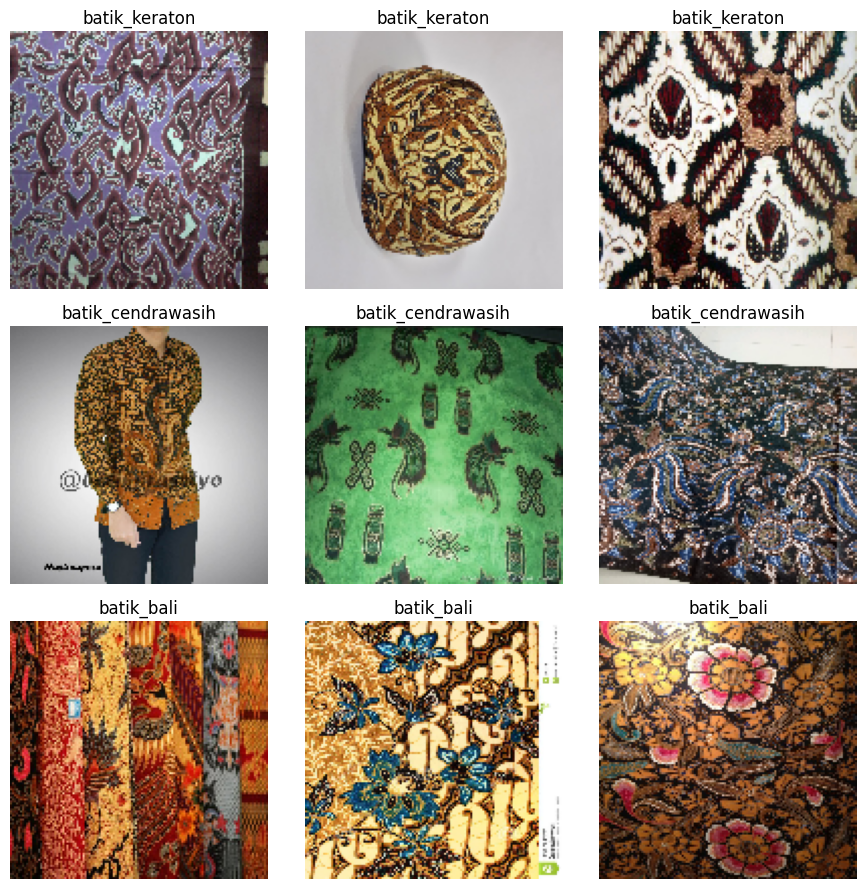

In [30]:
plt.figure(figsize=(9, 9))

# Display Batik Keraton
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(batik_keraton[i][0])  
    plt.title("batik_keraton")  
    plt.axis('off')

# Display Batik Cendrawasih
for i in range(3):
    plt.subplot(3, 3, i+4)
    plt.imshow(batik_cendrawasih[i][0])  
    plt.title("batik_cendrawasih")  
    plt.axis('off')

    
# Display Batik Bali
for i in range(3):
    plt.subplot(3, 3, i+7)
    plt.imshow(batik_bali[i][0])  
    plt.title("batik_bali")  
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [31]:
# Shuffling the data to make sure the images are randomized and there is no order in labels
data_shuffled, labels_shuffled = shuffle(data, labels, random_state=42)

train_images, test_images, train_labels, test_labels = train_test_split(data_shuffled, labels_shuffled, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (119, 128, 128, 3)
Train labels shape: (119,)
Validation data shape: (15, 128, 128, 3)
Validation labels shape: (15,)
Test data shape: (15, 128, 128, 3)
Test labels shape: (15,)


In [32]:
# normalize the image range
print("Before")
print(np.max(train_images))
print(np.min(train_images))

train_images=train_images/255
test_images=test_images/255
val_images=val_images/255

print("After")
print(np.max(train_images))
print(np.min(train_images))

Before
255
0
After
1.0
0.0


In [33]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer="Adam")
print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
epochs = 20 
batch_size = 32 

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting


history = model.fit(train_images, 
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                   callbacks=[early_stopping])


Epoch 1/20
1/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.3438 - loss: 0.7902

W0000 00:00:1716130561.304045     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3137 - loss: 0.8301 - val_accuracy: 0.3333 - val_loss: 1.6992
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2577 - loss: -0.1515 - val_accuracy: 0.3333 - val_loss: 6.0188
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2910 - loss: -0.5845 - val_accuracy: 0.3333 - val_loss: 13.8907
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3160 - loss: -6.3656 - val_accuracy: 0.3333 - val_loss: 60.8899
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2765 - loss: -21.2981 - val_accuracy: 0.3333 - val_loss: 152.8981
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3108 - loss: -38.1199 - val_accuracy: 0.3333 - val_loss: 311.3089


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Accuracy on Validation Set: 0.333 %


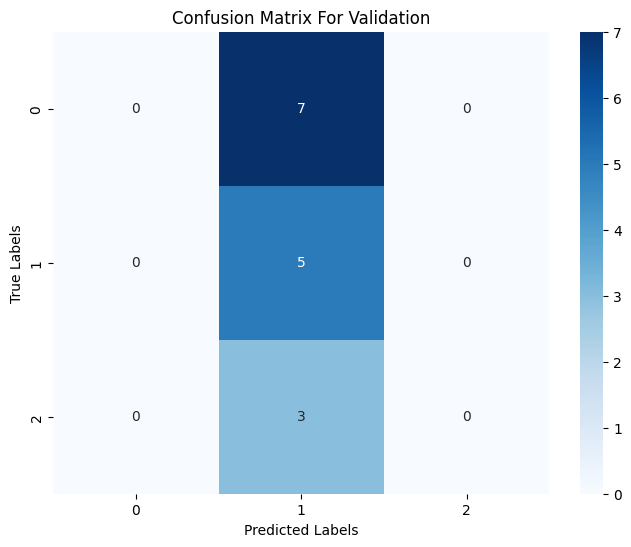

In [35]:
predictions = model.predict(val_images)
threshold = 0.5 
binary_predictions = (predictions > threshold).astype(int)

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# MODELING 

In [36]:
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Assuming your data is organized in one folder with subfolders for classes
data_dir = '/kaggle/input/indonesian-batik-motifs'

# Set image dimensions (adjust based on your pre-trained model)
img_width, img_height = 224, 224

# Define desired classes (modify based on your needs)
desired_classes = ['batik-sekar', 'batik-kawung', 'batik-betawi']

# Define number of classes (based on desired classes)
num_classes = len(desired_classes)

In [38]:
# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) # TRAIN DATA GET AUGMENTED HERE
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
# Include only desired classes during data loading
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=desired_classes
)

validation_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=desired_classes
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    classes=desired_classes,
    shuffle=False
)

Found 142 images belonging to 3 classes.
Found 142 images belonging to 3 classes.
Found 142 images belonging to 3 classes.


In [40]:
from tensorflow.keras.applications import EfficientNetB0  # Replace B0 with your variant

# Load the model without the top classification layer (include_top=False)
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


Exception: URL fetch failure on https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5: None -- [Errno -3] Temporary failure in name resolution

In [ ]:
# Optionally freeze pre-trained layers to prevent overfitting
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D for MobileNetV2
predictions = Dense(units=num_classes, activation='softmax')(x)

In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Adjust patience as needed
    
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=[Accuracy(), Precision(), Recall()])
    
# Train the model on training data and monitor validation data
model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[early_stopping])  # Adjust epochs as needed

In [ ]:
# Evaluate the model using the test data
test_steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)
predictions = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
    
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_classes, yticklabels=desired_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MobileNetV2')
plt.show()

In [ ]:
# Print the classification report
report = classification_report(y_true, y_pred, target_names=desired_classes)
print(f'Classification Report for MobileNetV2:\n{report}')